In [87]:
import jax
import jax.numpy as jnp

from tensorflow_probability.substrates import jax as tfp

import optax

# from rich import print
# from rich.table import Table

import matplotlib.pyplot as plt


In [88]:
dist = tfp.distributions

In [89]:
key = jax.random.PRNGKey(0)

In [90]:
# unnormalised distribution to be approximated

p = dist.MixtureSameFamily(
    mixture_distribution=dist.Categorical(probs=jnp.array([0.5, 0.5])),
    components_distribution=dist.Normal(loc=jnp.array([-0.2, 1]), scale=jnp.array([0.4, 0.5]))
)

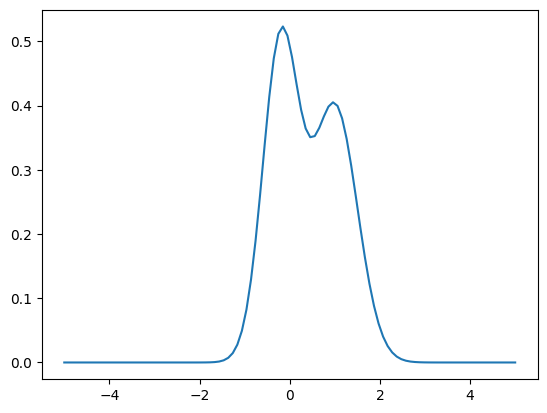

In [91]:
x = jnp.linspace(-5, 5, 100)
plt.plot(x, p.prob(x))

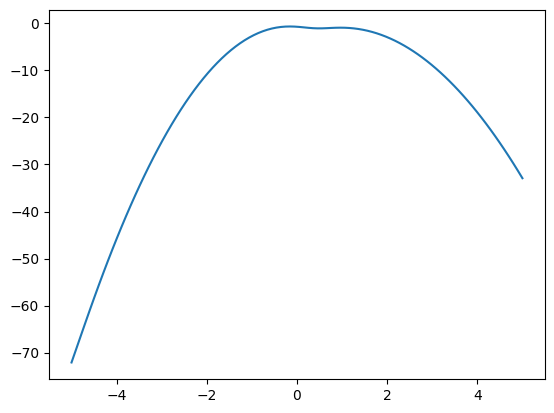

In [92]:
plt.plot(x, p.log_prob(x))

In [93]:
# computing KL divergence

In [94]:
q = dist.Normal(loc=0, scale=1)

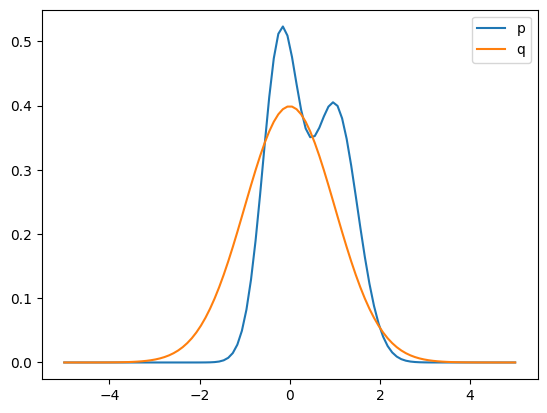

In [95]:
plt.plot(x, p.prob(x), label='p')
plt.plot(x, q.prob(x), label='q')
plt.legend()

In [96]:
q.kl_divergence(q, q)

Array(0., dtype=float32)

In [97]:
dist.kl_divergence(p, q)

NotImplementedError: No KL(distribution_a || distribution_b) registered for distribution_a type MixtureSameFamily and distribution_b type Normal

In [ ]:
# no closed form KL for these two distributions

In [ ]:
# we need to estimate it with MC sampling

In [98]:
def kl_via_sampling(p, q, n_samples=1000):
    key = jax.random.PRNGKey(1)
    q_samples = q.sample(
        seed=key,
        sample_shape=[n_samples]
    )
    #kl(q||p)
    # expectation of p(x) where x ~ q
    return jnp.mean(q.log_prob(q_samples) - p.log_prob(q_samples))

In [99]:
klv = kl_via_sampling(p, q)
klv

Array(0.7333999, dtype=float32)

In [100]:
# reparameterisation

# 1. we parameterise q via its parameters i.e. loc and scale
# 2. we generate samples from N(0,1) and then rescale them
# for q's loc and scale
# 3. KL-divergence and hence the loss is a function of the parameters
# of q and thus we can use autograd functionality

In [101]:
def kl_reparam(p, q_loc, q_scale, n_samples=1000):
    key = jax.random.PRNGKey(1)
    q = dist.Normal(loc=q_loc, scale=q_scale)
    N01 = dist.Normal(loc=0, scale=1)
    samples = N01.sample(seed=key, sample_shape=[n_samples,])
    samples = q_loc + q_scale * samples
    return jnp.mean(q.log_prob(samples) - p.log_prob(samples))

In [102]:
klv_rep = kl_reparam(p, 0, 1)

In [103]:
klv_rep

Array(0.7333999, dtype=float32)

In [104]:
# optimising the ELBO
# Evidence Lower BOund

In [162]:
@jax.jit
def kl_reparam(p, params, n_samples=1000, key=jax.random.PRNGKey(1)):
    q_loc, q_scale = params['loc'], params['scale']
    q = dist.Normal(loc=q_loc, scale=q_scale)
    N01 = dist.Normal(loc=0, scale=1)
    samples = N01.sample(seed=key, sample_shape=[n_samples,])
    samples = q_loc + q_scale * samples
    return jnp.mean(q.log_prob(samples) - p.log_prob(samples))

In [163]:
grad_loss = jax.grad(kl_reparam, argnums=(1))

In [164]:
params = {'loc':jnp.array([5.]), 'scale':jnp.array([1.])}

grad_theta_val = grad_loss(p, params)
grad_theta_val

{'loc': Array([15.805947], dtype=float32),
 'scale': Array([2.246283], dtype=float32)}

In [165]:
# optimizer = optax.adam(learning_rate=0.01)
optimizer = optax.sgd(learning_rate=0.01)
opt_state = optimizer.init(params)

In [166]:
import numpy as np

num_iter = 100
costs = np.empty(num_iter)
key = jax.random.PRNGKey(1)
for i in range(num_iter):
    key, subkey = jax.random.split(key)
    cost_val = kl_reparam(p, params, key = subkey)
    costs[i] = cost_val
    grads = grad_loss(p, params)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

In [167]:
costs[-1]

0.28096339106559753

Text(0, 0.5, 'Cost')

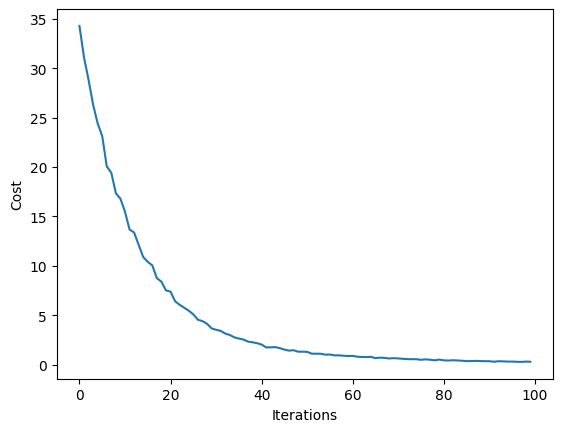

In [168]:
plt.plot(costs)
plt.xlabel("Iterations")
plt.ylabel("Cost")

In [169]:
params


{'loc': Array([0.88250905], dtype=float32),
 'scale': Array([0.6854753], dtype=float32)}

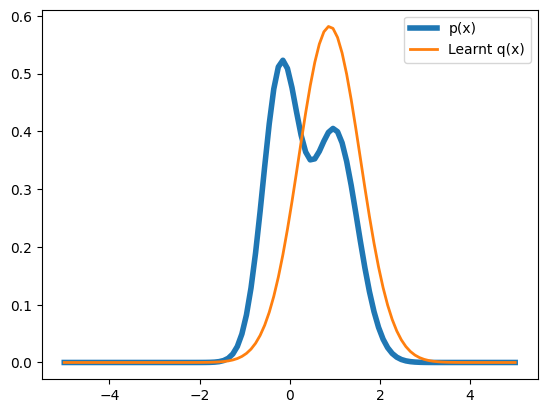

In [170]:
q_learnt = dist.Normal(loc=params["loc"], scale=params["scale"])
plt.plot(x, p.prob(x), label="p(x)", lw=4)
plt.plot(x, q_learnt.prob(x), label="Learnt q(x)", lw=2)
plt.legend()